ONE can operate in two modes. For very large collections, such as the main IBL data, it operates in "remote mode", downloading data from a remote store only as required. However it can also be used in "local mode", in which all data files are stored on the user's local machine. This is simpler, and allows access with no internet connection. To access data in local mode, a user uses exactly the same commands as in remote mode. 

The easiest way for data producers to release ONE-standard data is thus to create a directory containing your data files, collect them all into a .zip file, and put it on a website.  Users can then download and unzip your data files, and access them using ONE local mode. To allow searching in local mode, ONE creates a parquet-format index file, "sessions.pqt", which should also be included in the zip file.

In this tutorial we will show how to access data files in local mode and how to create the index file.

First we have to install ONE:

In [1]:
pip install ONE-api

     |████████████████████████████████| 70 kB 2.3 MB/s 
     |████████████████████████████████| 11.3 MB 8.0 MB/s 
     |████████████████████████████████| 73 kB 901 kB/s 
     |████████████████████████████████| 41 kB 287 kB/s 
     |████████████████████████████████| 68 kB 4.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.3 which is incompatible.


Next we are going to download an example collection of data files: the behavioral data released with [this paper](https://elifesciences.org/articles/63711). The following commands download a zip file from figshare into a cache directory, and unzip it. It is of course also possible to download and unzip the file manually, in any directory of the users choice. This should take around a minute.

In [4]:
from pathlib import Path

from one.api import One
from one.params import CACHE_DIR_DEFAULT
import requests
from io import BytesIO
import zipfile

# Data locations:
# The data_url is the location of the remote example dataset.  This will be downloaded so we
# have something to build a cache from on our local computer.
data_url = 'https://ndownloader.figshare.com/files/21623715'

# The cache_dir is the location of the example dataset.  By default this will be
# ~/Downloads/ONE/my_example but could be set to anything.
cache_dir = Path(CACHE_DIR_DEFAULT, 'my_example')

# Download data if not already downloaded
if not (cache_dir.exists() and any(cache_dir.iterdir())):
    cache_dir.parent.mkdir(exist_ok=True, parents=True)  # Create destination dir
    print(f'Downloading data from {data_url.split(".", maxsplit=1)[-1]}...')
    request = requests.get(data_url)  # Download data into memory (~300MB)
    with zipfile.ZipFile(BytesIO(request.content)) as zipped:
        print(f'Extracting into {cache_dir}...')
        zipped.extractall(path=cache_dir.parent)  # Decompress into destination dir
    Path(cache_dir.parent, 'ibl-behavioral-data-Dec2019').rename(cache_dir)  # Rename
    cache_dir.joinpath('one_example.py').unlink()  # Delete outdated example
    del request  # Free resources


Now let's have a look inside the directory. The data is stored in a hierarchical directory structure: lab/subject/date/number. So for the first recording made from Zador lab subject `CSH_ZAD_003` on 11 August 2019, the files are in the path `zadorlab/Subjects/CSH_ZAD_003/2019-08-11/001/alf`.  Within this directory, they are named with standard ONE file naming conventions.



In [5]:
import os
print(os.listdir(cache_dir))
print(os.listdir(cache_dir.joinpath('zadorlab/Subjects/CSH_ZAD_003/2019-08-11/001/alf')))

['danlab', 'wittenlab', 'cortexlab', 'README.txt', 'angelakilab', 'zadorlab', 'churchlandlab', 'mrsicflogellab', 'mainenlab', 'hoferlab']
['_ibl_trials.intervals.npy', '_ibl_trials.contrastRight.npy', '_ibl_trials.feedback_times.npy', '_ibl_trials.choice.npy', '_ibl_trials.included.npy', '_ibl_trials.goCue_times.npy', '_ibl_trials.contrastLeft.npy', '_ibl_trials.feedbackType.npy', '_ibl_trials.rewardVolume.npy', '_ibl_trials.repNum.npy', '_ibl_trials.probabilityLeft.npy', '_ibl_trials.stimOn_times.npy', '_ibl_trials.stimOnTrigger_times.npy', '_ibl_trials.response_times.npy', '_ibl_trials.goCueTrigger_times.npy']


Now the files are on your local drive you can use ONE search and load commands as you would with remote data. Let's search for all sessions of subject NYU-01, that have behavioral data (which we can tell because they have the file `_ibl_trials.intervals.npy`.  As usual, you can also search with wildcards.

In [8]:
one = One(cache_dir=cache_dir)

## Searching for behaviour experiment by subject
subject = 'NYU-01'
eids = one.search(subject=subject, dataset=['_ibl_trials.intervals.npy',])
print(f'There are {len(eids)} behaviour sessions for subject "{subject}"')

## Regex is supported in the search
subject = 'NYU-.*'
eids = one.search(subject=subject, dataset=['_ibl_trials.intervals.npy',])
print(f'There are {len(eids)} behaviour sessions with {subject} subjects')


There are 99 behaviour sessions for subject "NYU-01"
There are 492 behaviour sessions with NYU-.* subjects


Now let's load data for one of these sessions, and make a plot of reaction time vs. trial number, which we obtain by subtracting the time of the go cue onset from the feedback (i.e. reward or failure) time. 

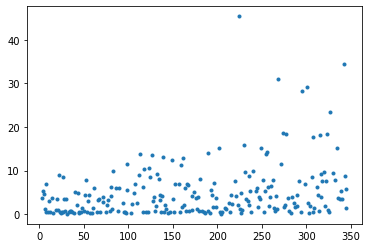

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data

# Load the trials object
trials = one.load_object(eids[0], '_ibl_trials')

# Load an individual dataset
goCue_times = one.load_dataset(eids[0], '_ibl_trials.goCue_times')
feedback_times = one.load_dataset(eids[0], '_ibl_trials.feedback_times')

plt.plot(feedback_times-goCue_times, '.')

Finally, let's see how you would release data in ONE standard if you are a data producer.  Before zipping and uploading, you need to create the index file, which is done with one line of code. This should take about 3 minutes for the current behavioral data . Note, the option `hash_files` creates a hash of each file which allows ONE to detect when files have changed - this is good for dynanmic data stored on an Alyx but is not necessary for release of zipped data on a website.


In [10]:
print('Building ONE cache from filesystem...')
One.setup(cache_dir, hash_files=False)

Building ONE cache from filesystem...


One (offline, /root/Downloads/ONE/my_example)

Now to release the data, just zip up the directory and upload to your favorite web hosting service!